In [158]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

import time

%matplotlib inline

In [2]:
def draw_solar_rot(ax, center, radius, facecolor='k', edgecolor='None', theta1=135, theta2=30):
    
    # Add the ring
    rwidth = radius/6
    ring = patches.Wedge(center, radius, theta1, theta2, width=rwidth)
    # Triangle edges
    offset = radius/3
    xcent  = center[0] + radius - (rwidth/2)
    left   = [xcent - offset - radius/10, center[1]+radius/5]
    right  = [xcent + offset, center[1]+radius/3]

    top = [xcent-7, center[1]+radius]
    arrow  = plt.Polygon([left, right, top, left])
    p = PatchCollection(
        [ring, arrow], 
        edgecolor = edgecolor, 
        facecolor = facecolor
    )
    ax.add_collection(p)

In [138]:
def plot_full_sun_EIT(fitsFileName, header, data, xcenter=512, ycenter=512, save=False, saveFileName=None):

    fig = plt.figure(figsize=(24,8))
    gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1:])
        
    cs = ax0.imshow(np.log10(data),cmap='Greys_r',interpolation='None',origin="lower")
    ax0.set_title('{0}, {1} angstroms,\n{2}'.format(header['SCI_OBJ'],header['WAVELNTH'],fitsFileName))
    
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes("right", size="5%", pad="2%")
    fig.add_axes(cax)
    fig.colorbar(cs, cax=cax,label="log_10(count)")

    rwidth = np.max(np.array((np.abs(xcenter-512),np.abs(ycenter-512)))) + 512

    rect0 = patches.Rectangle((xcenter, ycenter), width=rwidth, height = 1, linewidth=1, edgecolor='y', facecolor='none',angle=180.,rotation_point='xy')
    rect1 = patches.Rectangle((xcenter, ycenter), width=rwidth, height = 1, linewidth=1, edgecolor='m', facecolor='none')
    rect2 = patches.Rectangle((xcenter, ycenter), width=rwidth, height = 1, linewidth=1, edgecolor='r', facecolor='none',angle=270.,rotation_point='xy')
    rect3 = patches.Rectangle((xcenter, ycenter), width=rwidth, height = 1, linewidth=1, edgecolor='b', facecolor='none',angle=90.,rotation_point='xy')
        
    rect4 = patches.Rectangle((xcenter, ycenter), width=rwidth*np.sqrt(2), height = 1, linewidth=1, edgecolor='k', facecolor='none',angle=270+45.,rotation_point='xy')
    rect5 = patches.Rectangle((xcenter, ycenter), width=rwidth*np.sqrt(2), height = 1, linewidth=1, edgecolor='darkorange', facecolor='none',angle=180+45.,rotation_point='xy')
    rect6 = patches.Rectangle((xcenter, ycenter), width=rwidth*np.sqrt(2), height = 1, linewidth=1, edgecolor='g', facecolor='none',angle=90+45.,rotation_point='xy')
    rect7 = patches.Rectangle((xcenter, ycenter), width=rwidth*np.sqrt(2), height = 1, linewidth=1, edgecolor='c', facecolor='none',angle=45.,rotation_point='xy')
        
    for r in [rect0,rect1,rect2,rect3,rect4,rect5,rect6,rect7]:
        ax0.add_patch(r)
    
    draw_solar_rot(ax=ax0, center=(xcenter,950), radius=30, facecolor='k', edgecolor='k', theta1=135, theta2=30) 

    ax0.set_xlim(0,1024)
    ax0.set_ylim(0,1024)
    #axes[1].hist(np.ravel(data), color = 'k', alpha=0.5,range=(0,1500),bins=50,log=True)
    #axes[1].set_ylim(1.,1.e6)
    #axes[1].set_xlim(0.,1500)
    #axes[1].set_xlabel("counts/pixel")

    #data = np.log10(data)
    
    try:
        ax1.plot(np.arange(xcenter),data[ycenter,0:xcenter][::-1],'y-')
        ax1.plot(np.arange(1024-xcenter),data[ycenter,xcenter:],'m-')
        ax1.plot(np.arange(ycenter),data[0:ycenter,xcenter][::-1],'r-')
        ax1.plot(np.arange(1024-ycenter),data[ycenter:,xcenter],'b-')
        ax1.axvline(380,color='k',ls=':')
        ax1.axvline(512,color='k',ls='-')
        ax1.axhline(1,color='k',ls=':')


        ur_length = np.min(np.array((1024-ycenter, 1024-xcenter)))
        lr_length = np.min(np.array((1024-xcenter, ycenter)))
        ll_length = np.min(np.array((ycenter, xcenter)))
        ul_length = np.min(np.array((xcenter, 1024-ycenter)))
        ur = np.zeros(ur_length)
        lr = np.zeros(lr_length)
        ll = np.zeros(ll_length)
        ul = np.zeros(ul_length)

        for i in range(ur_length):
            ur[i] = data[ycenter+i,xcenter+i]

        for i in range(lr_length):
            lr[i] = data[ycenter-i,xcenter+i]

        for i in range(ll_length):
            ll[i] = data[ycenter-i,xcenter-i]

        for i in range(ul_length):
            ul[i] = data[ycenter+i,xcenter-i]
        
        ax1.plot(np.arange(lr_length)*np.sqrt(2),lr,'k-')
        ax1.plot(np.arange(ll_length)*np.sqrt(2),ll,color='darkorange',ls='-')
        ax1.plot(np.arange(ul_length)*np.sqrt(2),ul,'g-')
        ax1.plot(np.arange(ur_length)*np.sqrt(2),ur,'c-')
            
        ax1.set_ylim(1.e-2,2.e3)
        ax1.set_yscale("log")
        #ax1.set_xscale("log")
        ax1.set_xlim(-1,512*np.sqrt(2))
        ax1.set_xlabel("distance from center [pixels]")
        ax1.set_ylabel("count")
        
        #ax1.plot(np.arange(200)+380, np.exp(41*np.exp(-np.linspace(2,3.3,200))), 'k-',lw=2)
        #ax1.plot(np.arange(200)+380, np.exp(38*np.exp(-np.linspace(2,4.1,200))), 'k-',lw=2)

    except IndexError:
        pass
        
    plt.subplots_adjust(wspace=0.275)

    if save is True:
        plt.savefig("{0}".format(saveFileName),bbox_inches="tight")
        plt.close()
    else:
        plt.show()

    return

In [134]:
def plot_other_EIT(fitsFileName, header, data, save=False, saveFileName=None):
    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    ax0 = fig.add_subplot(gs[0, 0])
        
    cs = ax0.imshow(np.log10(data),cmap='Greys_r',interpolation='None',origin="lower")
    ax0.set_title('{0}, {1}'.format(header['SCI_OBJ'], fitsFileName))
    
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes("right", size="5%", pad="2%")
    fig.add_axes(cax)
    fig.colorbar(cs, cax=cax,label="log_10(count)")

    if save is True:
        plt.savefig("{0}".format(saveFileName),bbox_inches="tight")
        plt.close()
    else:
        plt.show()

    return 

In [89]:
def make_disk_model(sidelength=1024,xcenter=512,ycenter=512,radius=953.884775291/2.627):
    """
    make a square array of shape (sidelength, sidelength) where 
    all pixels within "radius" of (xcenter,ycenter) have value 1
    all other pixels have value 0
    """
    square = np.zeros((sidelength,sidelength))
    square_idxs = np.indices((sidelength,sidelength))

    disk_mask = ( (square_idxs[0,:,:] - ycenter)**2 + (square_idxs[1,:,:] - xcenter)**2 <= radius**2)

    square[disk_mask] = 1.
    
    return square


In [176]:
def make_disk_corona_model(sidelength=1024,xcenter=512,ycenter=512,radius=953.884775291/2.627):
    """
    make a square array of shape (sidelength, sidelength) where 
    all pixels within "radius" of (xcenter,ycenter) have value 1
    all other pixels have value 0
    """
    square = np.zeros((sidelength,sidelength))
    square_idxs = np.indices((sidelength,sidelength))

    disk_mask = ( (square_idxs[0,:,:] - ycenter)**2 + (square_idxs[1,:,:] - xcenter)**2 < (0.95*radius)**2 )

    square[disk_mask] = 1.

    corona_mask =( ((square_idxs[0,:,:] - ycenter)**2 + (square_idxs[1,:,:] - xcenter)**2 >= (0.95*radius)**2)
                  & ((square_idxs[0,:,:] - ycenter)**2 + (square_idxs[1,:,:] - xcenter)**2 <= (1.05*radius)**2) )

    square[corona_mask] = np.sqrt(10.)
    
    return square


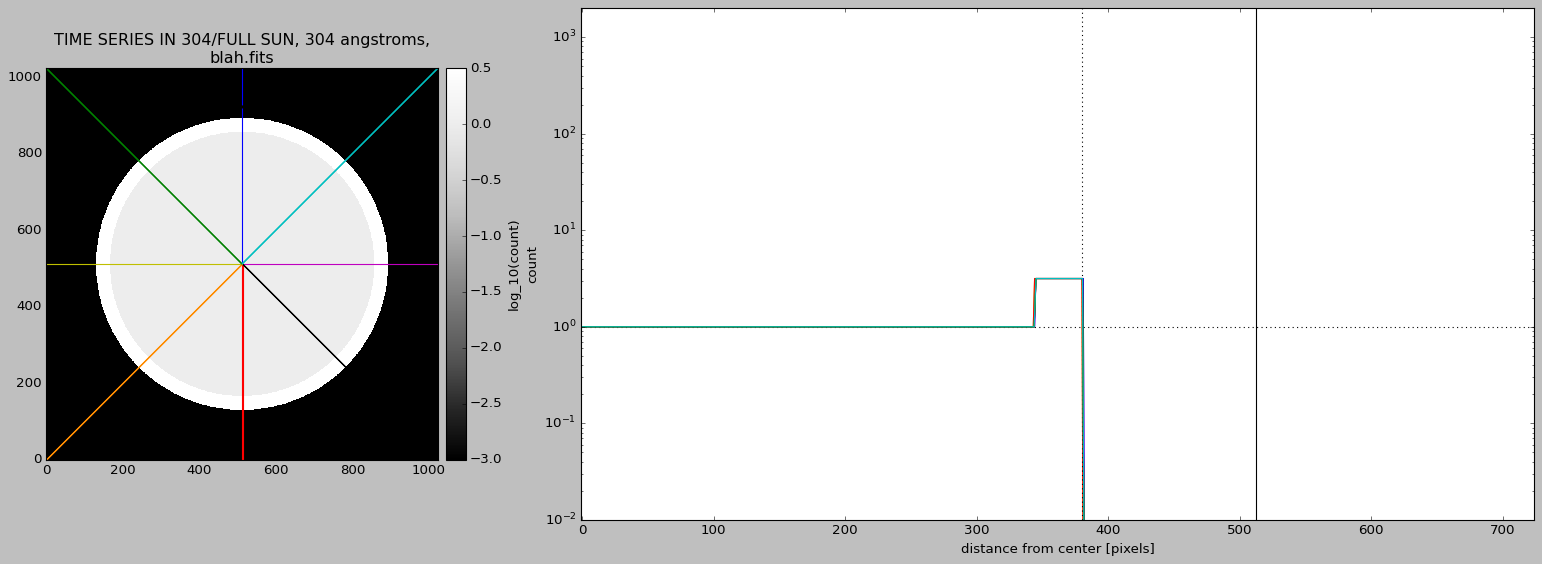

In [177]:
test = make_disk_corona_model()
test = test+0.001
#fig, ax = plt.subplots(1,1,figsize=(8,8))
#ax.imshow(test,cmap='Greys_r',origin='lower',interpolation='None')
#plt.show()
plot_full_sun_EIT(fitsFileName='blah.fits', header=header, data=test)

In [178]:
def chi_squared(data, model):
    """
    no uncertainties
    """
    return np.sum( (data - model)**2 )

In [195]:
def fit_solar_center(data, header, guess_xcenter, guess_ycenter, search_box_radius):
    """
    fit a very approximate disk + corona model to find the indices of the pixel at the center of the solar disk
    """

    solRadPixels = header['RSUN_ARC']/header['CDELT1']
    bestChiSquared = chi_squared(data, make_disk_corona_model(sidelength=1024,xcenter=guess_xcenter,ycenter=guess_ycenter,radius=solRadPixels))

    #chiSquaredGrid = np.zeros((2*search_box_radius + 1, 2*search_box_radius+1))
    
    for i in range(-search_box_radius, search_box_radius+1):
        for j in range(-search_box_radius, search_box_radius+1):
            chiSquared = chi_squared(data, make_disk_corona_model(sidelength=1024,xcenter=guess_xcenter+j,ycenter=guess_ycenter+i,radius=solRadPixels))
            #chiSquaredGrid[i+search_box_radius, j+search_box_radius] = chiSquared
            if chiSquared <= bestChiSquared:
                #print(chiSquared)
                bestChiSquared = chiSquared
                xcenter = guess_xcenter+j
                ycenter = guess_ycenter+i
                #print(xcenter,ycenter)

    return xcenter, ycenter#, chiSquaredGrid
    

510 505
511 505
512 505
513 505
514 505
515 505
516 505
517 505
518 505
519 505
510 509
511 509
512 509
513 509
514 509
515 509
516 509
517 509
518 509
519 509
520 509
510 511
511 511
512 511
513 511
514 511
515 511
516 511
517 511
518 511
519 511
520 511
510 512
511 512
512 512
513 512
514 512
515 512
516 512
517 512
518 512
519 512
520 512
511 513
512 513
514 513
515 513
517 513
518 513
519 513
520 513


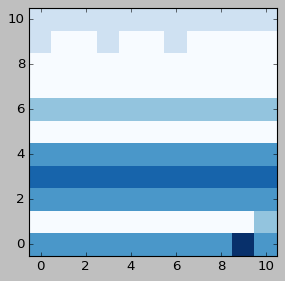

5.416661977767944
520
513


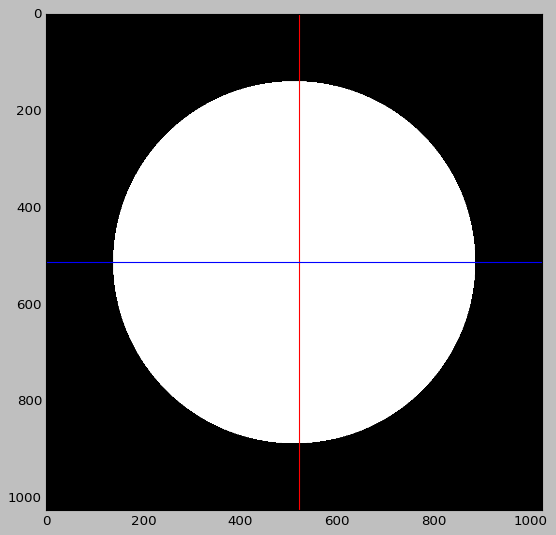

In [193]:
start = time.time()
test = make_disk_model(xcenter=512,ycenter=512,radius=header['RSUN_ARC']/header['CDELT1'])
#test = make_disk_corona_model(sidelength=1024,xcenter=512,ycenter=512,radius=header['RSUN_ARC']/header['CDELT1'])
xcenter, ycenter, csg = fit_solar_center(data=test, header=header, guess_xcenter=515, guess_ycenter=509, search_box_radius = 5)
end = time.time()

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.imshow(csg,cmap='Blues',origin='lower',interpolation='None')
plt.show()

print((end-start))
print(xcenter)
print(ycenter)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(test,cmap='Greys_r')
ax.axvline(xcenter, color = 'r')
ax.axhline(ycenter, color = 'b')
plt.show()


In [ ]:
test_f = "./EIT/1996/02/01/SOHO_EIT_304_19960201T042050_L1.fits"
hdul = fits.open(test_f)
data = hdul[0].data
header = hdul[0].header
xcenter, ycenter = find_solar_center(data)
print(xcenter)
print(ycenter)

xcenter, ycenter = fit_solar_center(data, header, search_box_radius=100)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(data,cmap='Greys_r',origin='lower',interpolation='None')
ax.axvline(xcenter, color = 'r')
ax.axhline(ycenter, color = 'b')
plt.show()

In [131]:
def find_solar_center(data):
    """
    find the indices of the pixel at the center of the sun. this doesn't work if the whole disk isn't in the image!
    """
    sumOverColumns = np.sum(data,1)
    sumOverRows = np.sum(data,0)

    x_convolution = np.convolve(sumOverRows, sumOverRows)
    y_convolution = np.convolve(sumOverColumns, sumOverColumns)

    center_x = int(np.ceil(np.argmax(x_convolution)/2))
    center_y = int(np.ceil(np.argmax(y_convolution)/2))
    '''
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.plot(np.arange(1024),sumOverColumns,'k-')
    ax.plot(np.arange(1024),sumOverRows,'r-')
    #ax.plot(x_convolution, 'k-')
    #ax.plot(y_convolution, 'r-')
    ax.axvline(center_x, color='r')
    ax.axvline(center_y, color='k')
    plt.show()
    '''
    return center_x, center_y

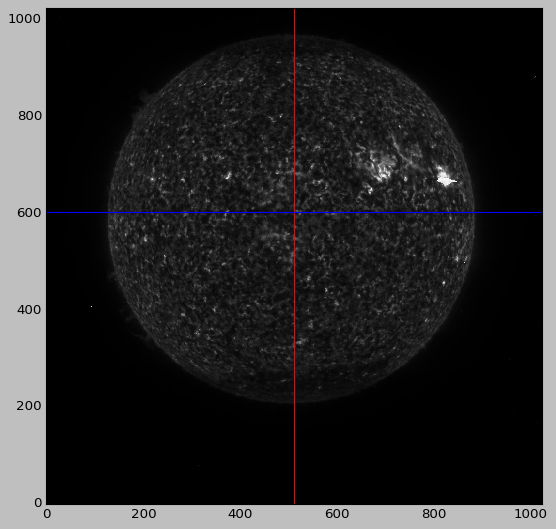

In [149]:
test_f = "./EIT/1996/02/01/SOHO_EIT_304_19960201T042050_L1.fits"
hdul = fits.open(test_f)
data = hdul[0].data
header = hdul[0].header
xcenter, ycenter = find_solar_center(data)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(data,cmap='Greys_r',origin='lower',interpolation='None')
ax.axvline(xcenter, color = 'r')
ax.axhline(ycenter, color = 'b')
plt.show()


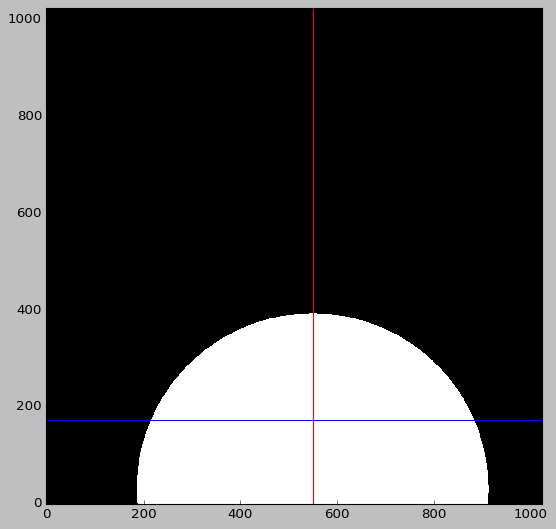

In [121]:
test = make_disk_model(xcenter=550,ycenter=30)
xcenter, ycenter = find_solar_center(test)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(test,cmap='Greys_r',origin='lower',interpolation='None')
ax.axvline(xcenter, color = 'r')
ax.axhline(ycenter, color = 'b')
plt.show()


In [102]:
def findCoL(data):
    """
    find the indices of the pixel at the center of light in the image
    if the disk overlaps the edge of the image, this will not be the same as the center of the disk!
    """

    #center of light x, y coordinates

    #sum over columns = total light in each row
    sumOverColumns = np.sum(data,1)
    sumOverRows = np.sum(data,0)

    CoL_x = np.average(np.arange(np.shape(data)[1]), weights=sumOverRows)
    CoL_y = np.average(np.arange(np.shape(data)[0]), weights=sumOverColumns)

    return CoL_x, CoL_y
    

In [38]:
#Systematically save examples of images corresponding to every unique scientific objective in 1996.
sci_objs = []
dates = []
examplefpaths = []

#for year in range(1996, 2010):
for year in [1996]:  
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])

        for d in days:
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            
            for f in fitsFiles:
                #print(f.name)
                hdul = fits.open(f.path)
                header = hdul[0].header

                sci_objs.append(header['SCI_OBJ'])
                dates.append(header['DATE-BEG'])
                examplefpaths.append(f.path)

uniq_sci_objs = []
example_uniq_sci_objs = []
for i in range(len(sci_objs)):
    if sci_objs[i] not in uniq_sci_objs:
        #print(sci_objs[i])
        #print(dates[i])
        uniq_sci_objs.append(sci_objs[i])
        example_uniq_sci_objs.append(examplefpaths[i])

In [39]:
print(len(uniq_sci_objs))
print(uniq_sci_objs)
#print(example_uniq_sci_objs)

176
['DARK IMAGE', 'First light', 'Stray light test', 'Second Light', 'SYNOPTIC FULL SUN', 'TIME SERIES IN 171/FULL SUN', 'Time Series 195', 'TIME SERIES IN 284/FULL SUN', 'TIME SERIES IN 304/FULL SUN', 'WEST LIMB/BAD COORDS', 'TIME SERIES IN 304', 'Time series in 304', 'Time Series in 171', 'Time Series in 195', 'Time Series in 304', 'Time series in 195', 'FILTER SEQUENCE IN 171', 'FILTER SEQUENCE IN 195', 'SOUTH POLE/EXPOSURE TEST', 'TIME SERIES IN 195', 'Submode 2 test', 'Submode 3 test', 'FILTER SEQUENCE IN 304', '284 SEQUENCE IN AL INF', 'FILTER SEQUENCE IN 284', '284 SEQUENCE CLEAR', 'TIME SERIES IN 284', 'FULL SUN 195/284/171/304', 'FULL SUN 195', 'INTERCALIBRATION 001', 'JOP_039_TEST', 'FLUSH Q BLOCK', 'JOP_039 POLAR PLUMES', 'SOUTH EAST', 'CALIBRATION LAMP', 'NORTH EAST', 'GRID TEST', '2x2  CCD BIN TEST', 'J1 ROLL +181.38', 'J1 ROLL +91.64', 'TIME SEQUENCE IN 195', 'CONTINUOUS RO TEST', 'J3 Offpoint Test', 'WEST LIMB', 'J3 OFFPOINT PREP', 'J3 OFFPOINT', 'XBP', 'OBE TESTING', '

486 518


/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_8200/4236348843.py:8: RuntimeWarning: invalid value encountered in log10
  cs = ax0.imshow(np.log10(data),cmap='Greys_r',interpolation='None',origin="lower")


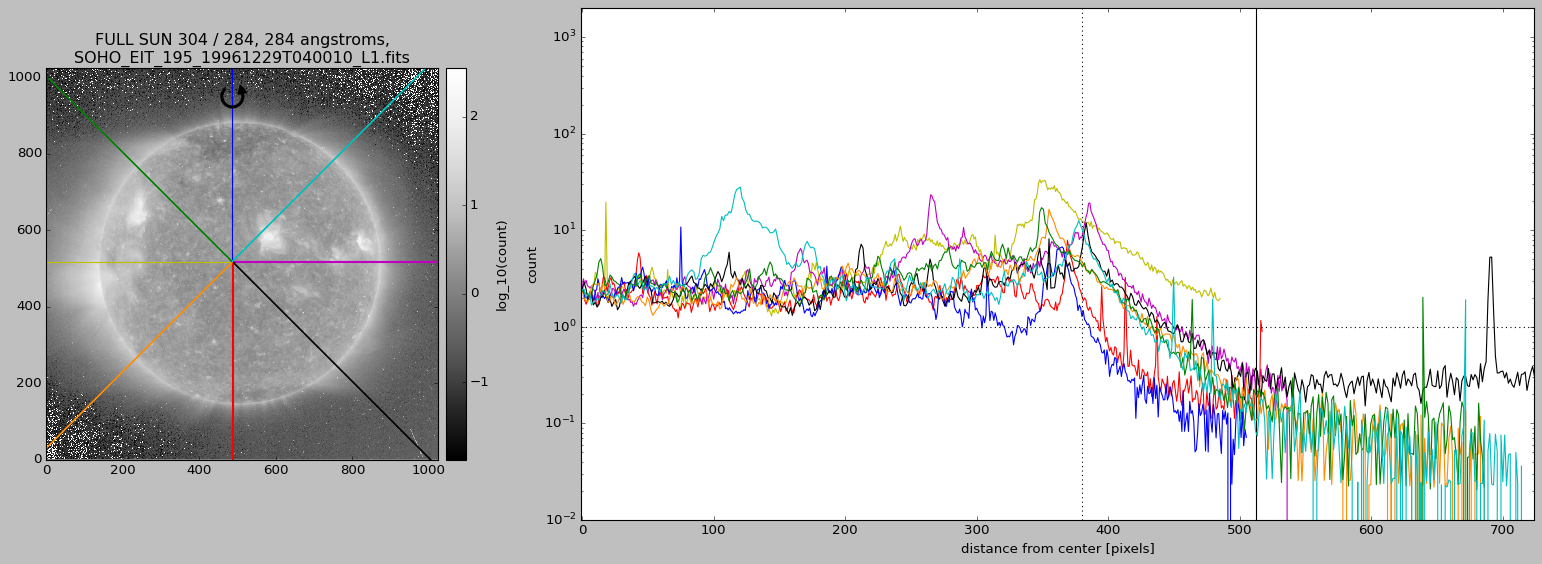

505 515


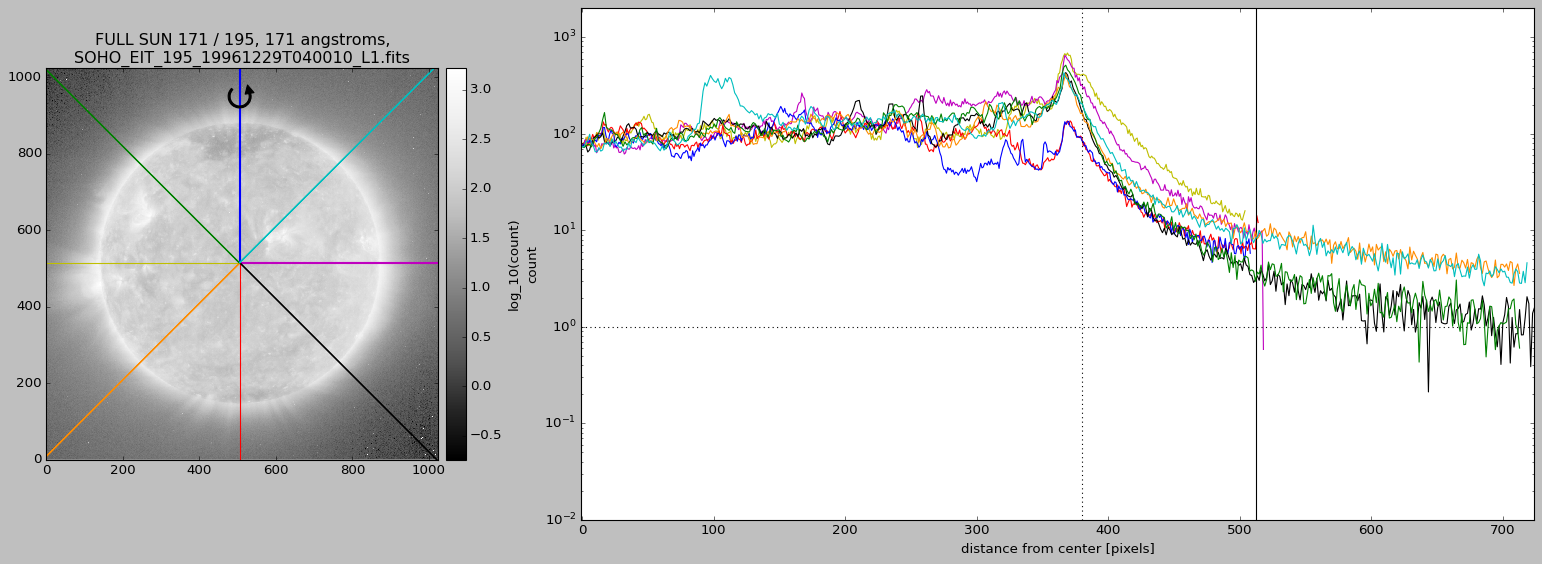

502 513


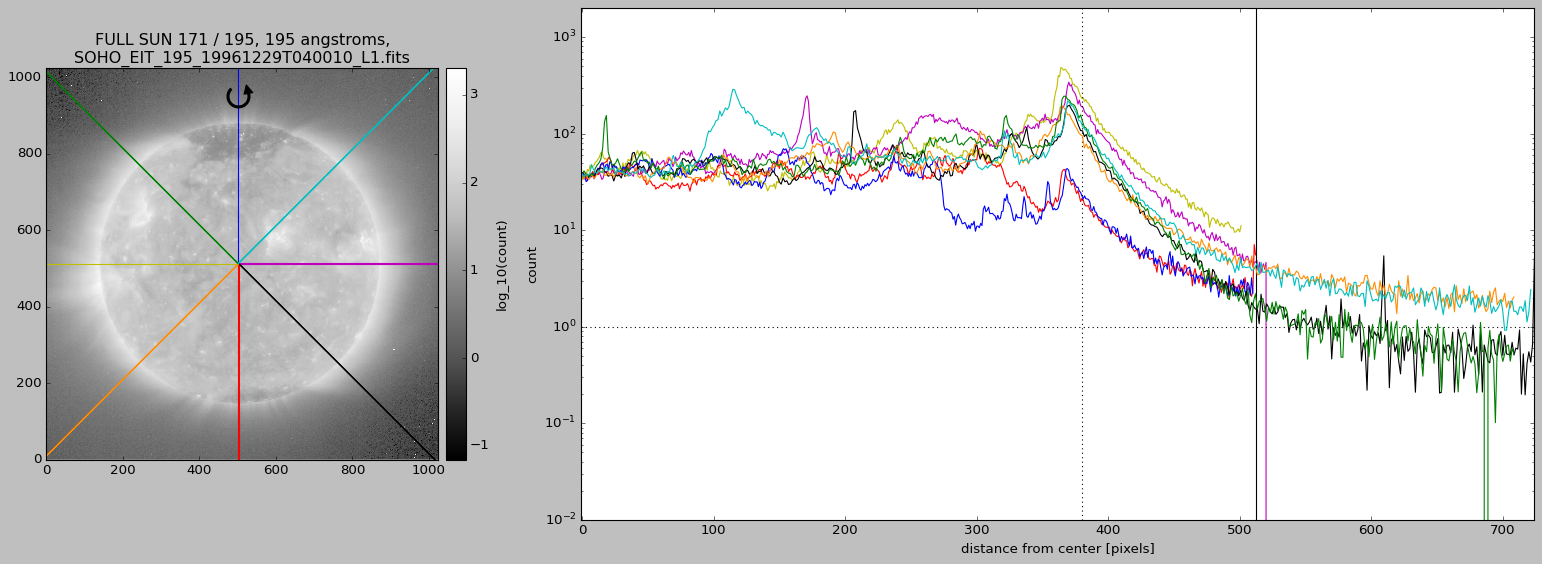

501 514


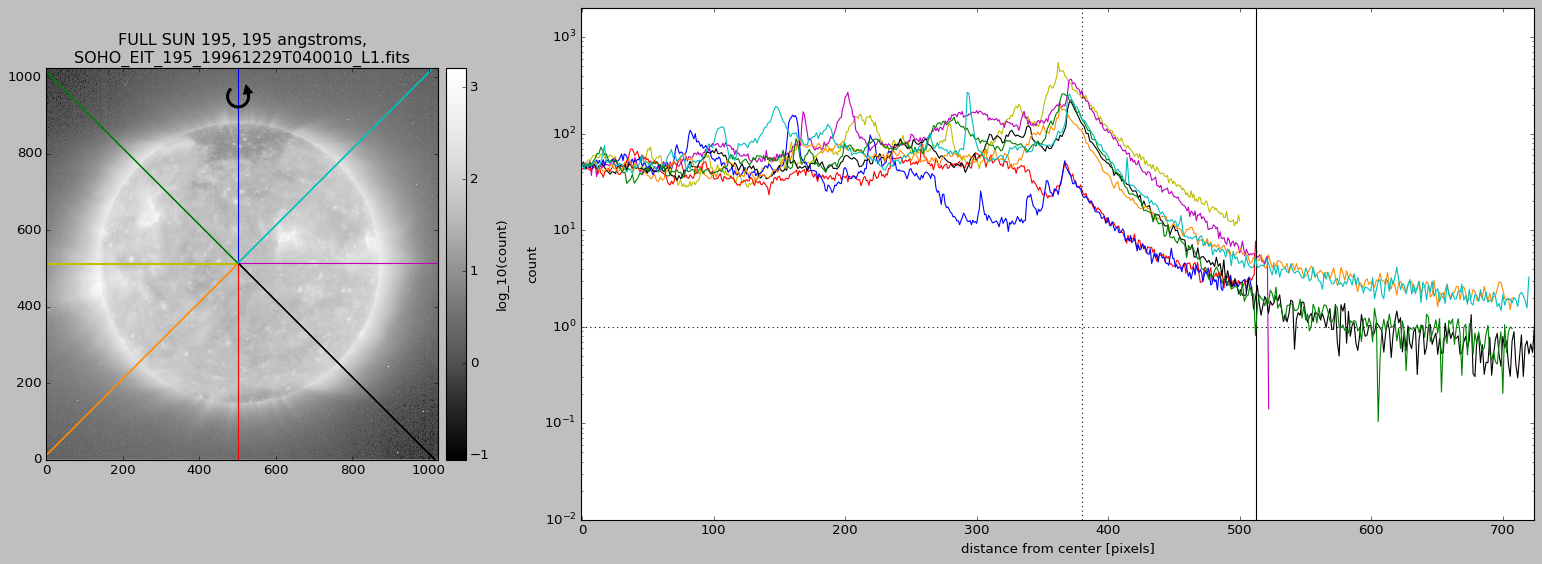

505 517


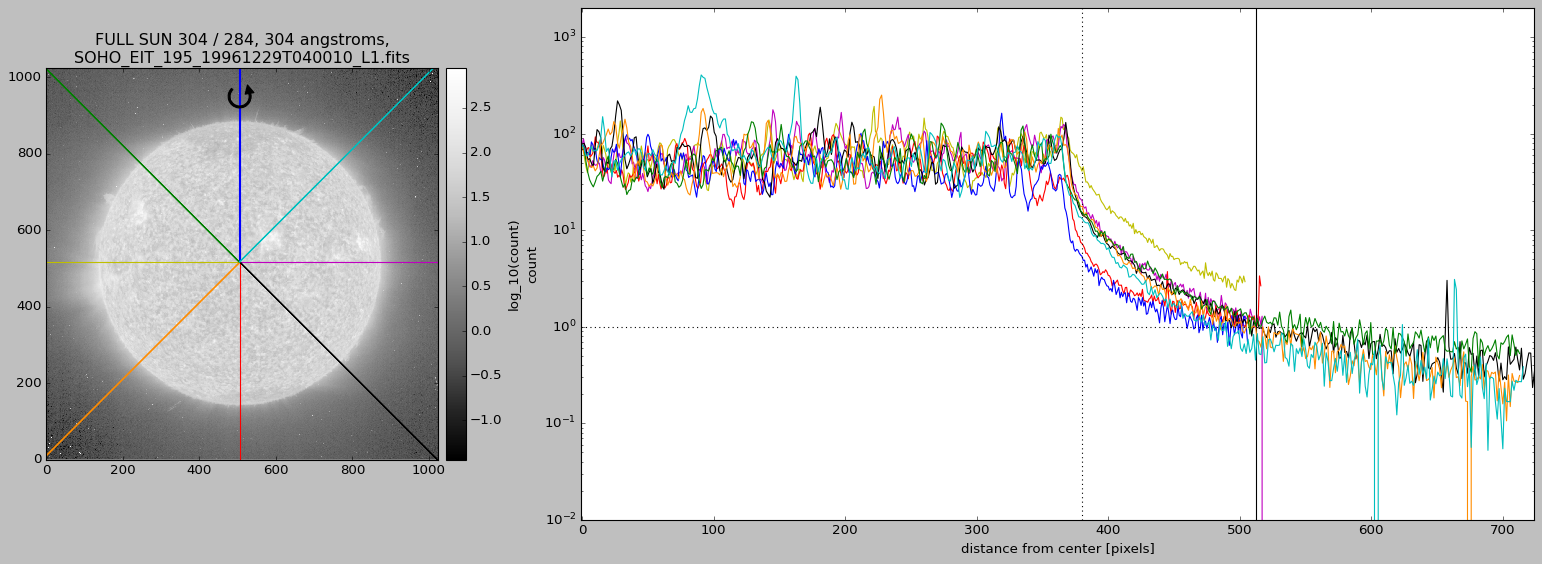

504 515


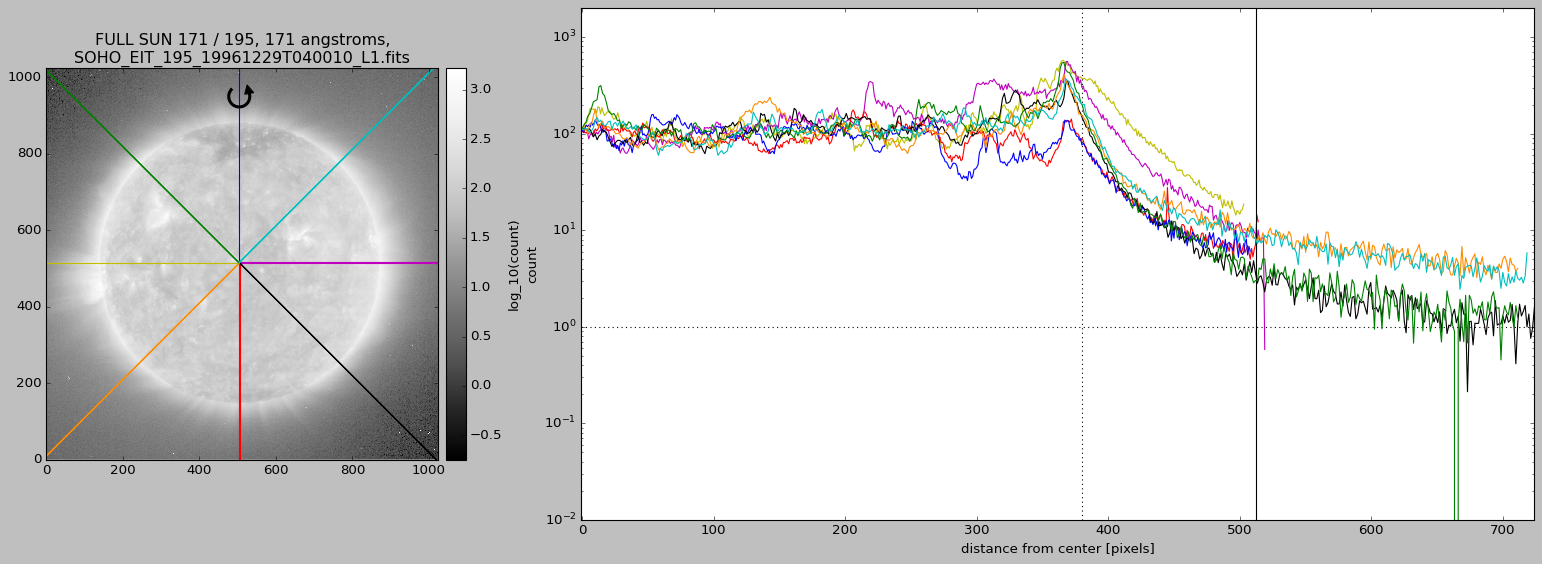

498 514


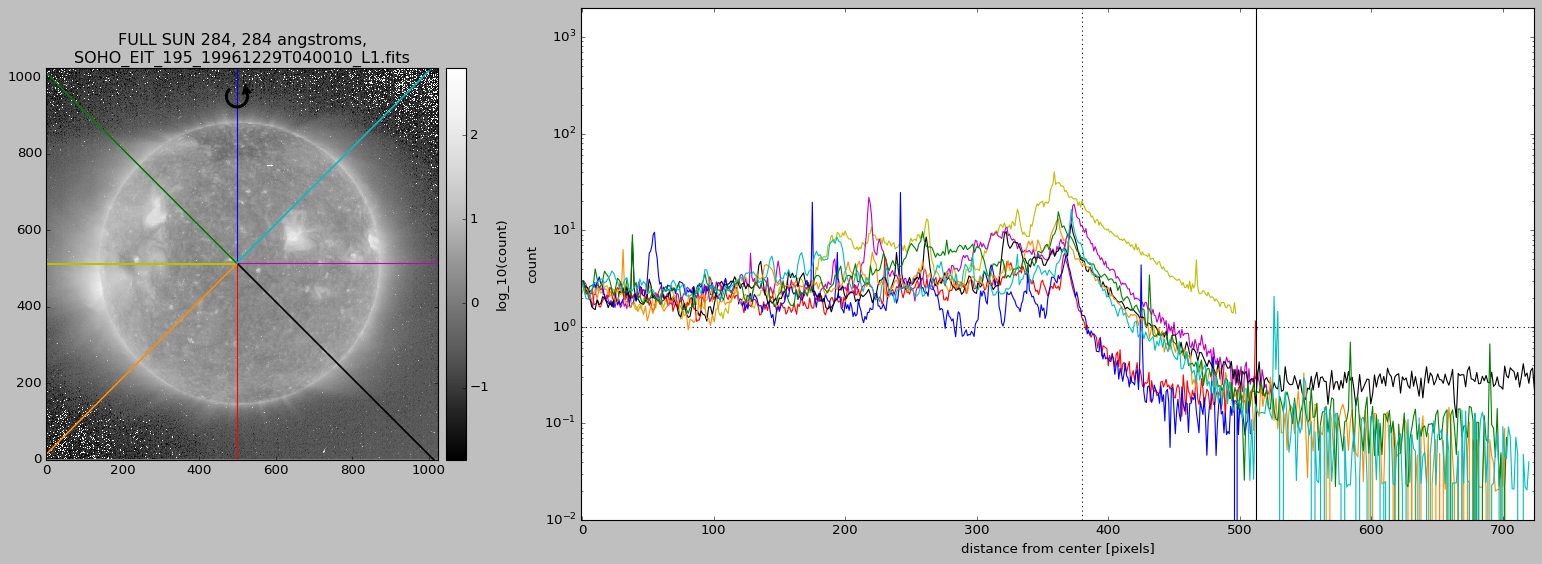

503 514


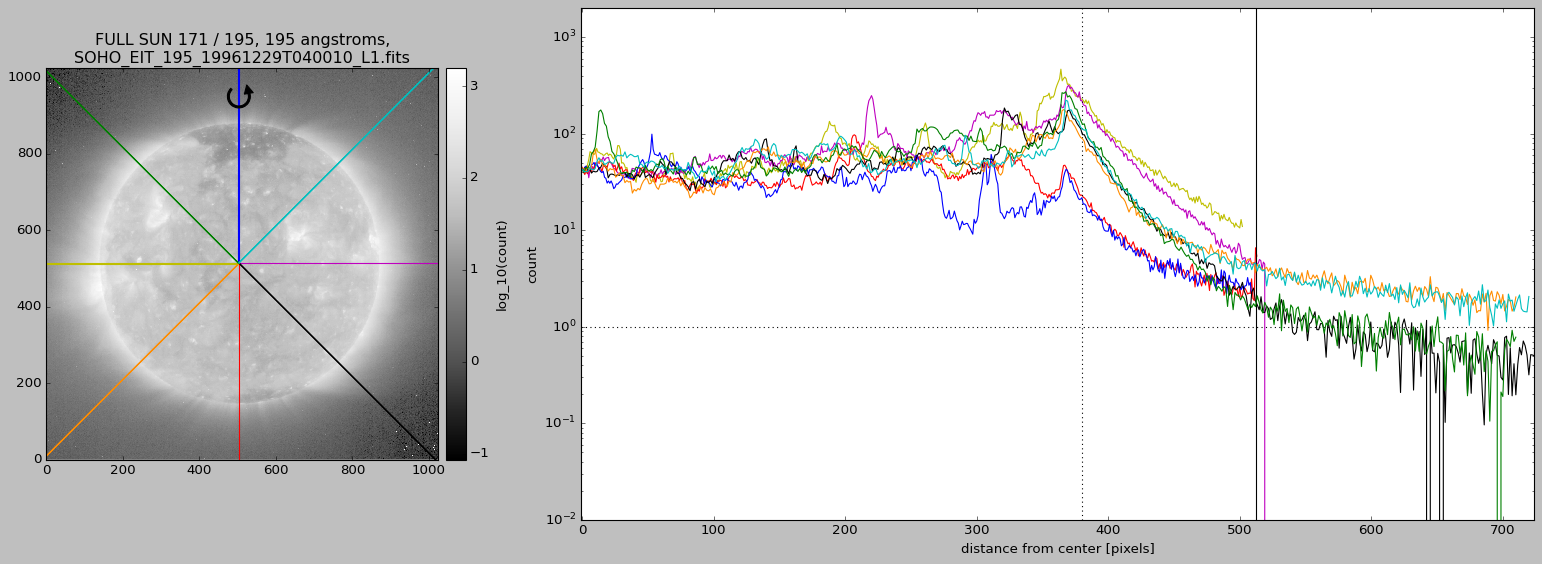

502 519


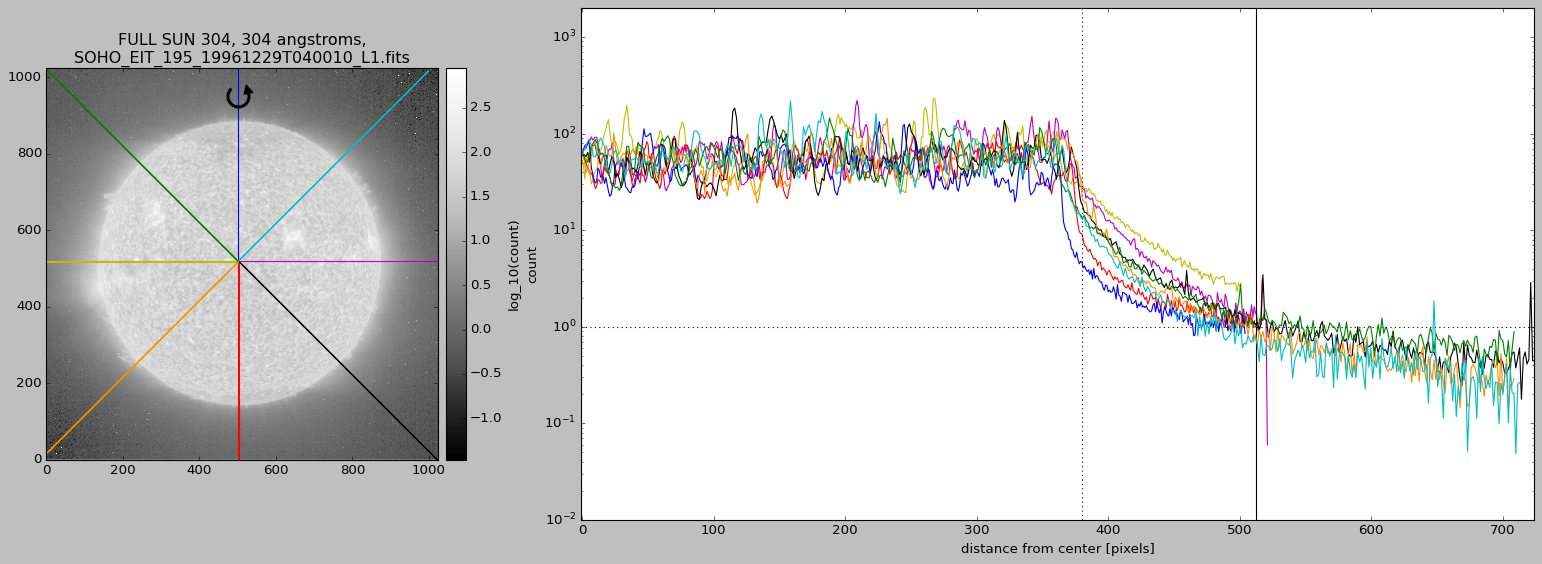

0
0


In [197]:
#testFITS = os.scandir("./EIT/1996/01/01/")
#testFITS = os.scandir("./EIT/1996/engineering/")
counter = 0
fullcounter = 0
#for fpath in example_uniq_sci_objs:
#for fpath in examplefpaths[-100:]:
for f in os.scandir("./EIT/1996/06/30"):
    hdul = fits.open(f.path)
    header = hdul[0].header
    data = hdul[0].data

    #print(header['SCI_OBJ'])

    sci_obj_ = header['SCI_OBJ'].replace("/"," ").replace(" ","_").lower()
    #print(sci_obj_)

    #if "full_sun" in sci_obj_:
    #    plot_full_sun_EIT(fpath.split("/")[-1], header, data, save=True, saveFileName="./EIT/1996ImageTypeExamples/{0}.png".format(sci_obj_))

    #else:
    #    plot_other_EIT(fpath.split("/")[-1], header, data, save=True, saveFileName="./EIT/1996ImageTypeExamples/{0}.png".format(sci_obj_))

    if "time_series" in sci_obj_:
        pass
        #xcenter,ycenter = find_solar_center(data)
        #plot_full_sun_EIT(fpath.split("/")[-1], header, data, xcenter=xcenter, ycenter=ycenter)
        #counter += 1
    elif "full_sun" in sci_obj_:
        guess_xcenter,guess_ycenter = find_solar_center(data)
        xcenter, ycenter = fit_solar_center(data, header, guess_xcenter, guess_ycenter, search_box_radius=5)
        print(xcenter,ycenter)
        plot_full_sun_EIT(fpath.split("/")[-1], header, data, xcenter=xcenter, ycenter=ycenter)
        #fullcounter += 1
    #signal = np.sum(data)
    #noise = np.sqrt(np.sum(data) + 1024*1024*852.)
    #print("signal is {0}".format(signal))
    #print("sqrt(signal) is {0}".format(np.sqrt(signal)))
    #print("noise is {0}".format(noise))
    #print("SNR is {0}".format(signal/noise))

    hdul.close()
print(counter)
print(fullcounter)

In [47]:
print(len(examplefpaths))

6792


In [48]:
6792 - (494+5621)

677